# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

  Using cached tensorflow-2.4.1-cp37-cp37m-win_amd64.whl (370.7 MB)
  Using cached tensorflow_gpu-2.4.1-cp37-cp37m-win_amd64.whl (370.7 MB)
  Using cached opencv_python-4.5.3.56-cp37-cp37m-win_amd64.whl (34.9 MB)
  Using cached matplotlib-3.4.3-cp37-cp37m-win_amd64.whl (7.2 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached h5py-2.10.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Using cached grpcio-1.32.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached numpy-1.19.5-cp37-cp37m-win_amd64.whl (13.2 MB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached wrapt-1.12.1-cp37-cp37m-win_amd64.whl
  Using cached protobuf-3.17.3-cp37-cp37m-win_amd64.whl (909 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [1]:
# http://vis-www.cs.umass.edu/lfw/

In [2]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [14]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [5]:
# Import uuid library to generate unique image names
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\03301c4a-1c06-11ec-b73a-a0cec8d2d278.jpg'

In [46]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(4)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

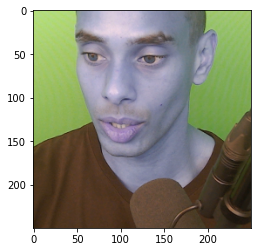

In [28]:
plt.imshow(frame[120:120+250,200:200+250, :])

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'data\\anchor\\9c45c888-135f-11ec-a5e7-a0cec8d2d278.jpg'


## 3.2 Preprocessing - Scale and Resize

In [10]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [11]:
img = preprocess('data\\anchor\\a4e73462-135f-11ec-9e6e-a0cec8d2d278.jpg')

In [12]:
img.numpy().max() 

1.0

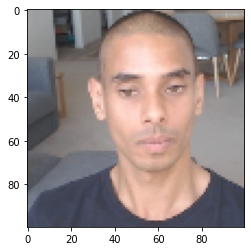

In [13]:
plt.imshow(img)

In [ ]:
dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [30]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [14]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
samples = data.as_numpy_iterator()

In [17]:
exampple = samples.next()

In [18]:
exampple

(b'data\\anchor\\9e8d3da2-135f-11ec-acef-a0cec8d2d278.jpg',
 b'data\\positive\\e5621852-135f-11ec-9288-a0cec8d2d278.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*exampple)

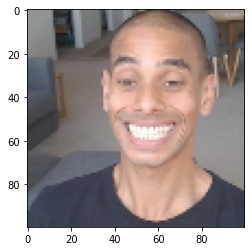

In [21]:
plt.imshow(res[1])

In [74]:
res[2]

1.0

In [22]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [23]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [101]:
inp = Input(shape=(100,100,3), name='input_image')

In [102]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [103]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [104]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [105]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [106]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [108]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [109]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 9, 9, 128)         0 

In [122]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [123]:
embedding = make_embedding()

In [124]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [119]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [120]:
l1 = L1Dist()

In [121]:
l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [127]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [128]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [131]:
siamese_layer = L1Dist()

In [135]:
distances = siamese_layer(inp_embedding, val_embedding)

In [136]:
classifier = Dense(1, activation='sigmoid')(distances)

In [137]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_5')>

In [139]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [141]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[1][0]     

In [142]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [143]:
siamese_model = make_siamese_model()

In [144]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[3][0]     

# 5. Training

## 5.1 Setup Loss and Optimizer

## 5.2 Establish Checkpoints

## 5.3 Build Train Step Function

## 5.4 Build Training Loop

## 5.5 Train the model

# 6. Evaluate Model

# 7. Save Model

# 8. Real Time Test